In [41]:
import pandas as pd
import numpy as np
import re
import geopy
from geopy.distance import vincenty
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# 1. Trips 

## 1.1  handle the trips data for specific route

In [42]:
i = "47"
# Change csv file for specific route
filename = "trips_routes/trips_" + i + ".txt"
trips = pd.read_csv(filename, sep=';',names = ["datasource","dayofservice","tripid","lineid","routeid","direction","plannedtime_arr","plannedtime_dep","actualtime_arr","actualtime_dep","basin","tenderlot","suppressed","justificationid","lastupdate","note"])
trips.head()

,datasource,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,basin,tenderlot,suppressed,justificationid,lastupdate,note
0,DB,09-FEB-16 00:00:00,2815315,47,47_136,2,27394,23400,NaN,23414.0,BasDef,NaN,NaN,NaN,12-APR-16 09:35:20,",2589933,"
1,DB,02-APR-16 00:00:00,2906794,47,47_139,1,44280,41400,44713.0,NaN,BasDef,NaN,NaN,NaN,28-APR-16 11:33:30,",2452512,"
2,DB,09-FEB-16 00:00:00,2823302,47,47_138,1,53880,50400,54733.0,50796.0,BasDef,NaN,NaN,NaN,12-APR-16 09:35:20,",2576041,"
3,DB,02-APR-16 00:00:00,2900071,47,47_136,2,59357,55800,NaN,56114.0,BasDef,NaN,NaN,NaN,28-APR-16 11:33:30,",2451831,"
4,DB,07-MAR-16 00:00:00,2887027,47,47_135,2,44880,41400,NaN,41454.0,BasDef,NaN,NaN,NaN,16-APR-16 10:02:17,",2589942,"


In [43]:
trips.shape

(11882, 16)

## 1.2  preprocessing the trips table

In [44]:
# Drop duplicates
trips = trips.drop_duplicates()

In [45]:
# Convert day of service to date time
trips['dayofservice'] = pd.to_datetime(trips['dayofservice'])

In [46]:
# The lineid of trips are all specific route, So could be dropped.
trips = trips.drop(['lineid','datasource','basin','tenderlot','lastupdate','note'], axis=1)

In [47]:
#rename the tripid to tripID which enable merging the two tables
trips.rename(columns ={'tripid':"tripID"},inplace = True )

In [48]:
trips.head()

,dayofservice,tripID,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,suppressed,justificationid
0,2016-02-09,2815315,47_136,2,27394,23400,NaN,23414.0,NaN,NaN
1,2016-04-02,2906794,47_139,1,44280,41400,44713.0,NaN,NaN,NaN
2,2016-02-09,2823302,47_138,1,53880,50400,54733.0,50796.0,NaN,NaN
3,2016-04-02,2900071,47_136,2,59357,55800,NaN,56114.0,NaN,NaN
4,2016-03-07,2887027,47_135,2,44880,41400,NaN,41454.0,NaN,NaN


In [49]:
trips.notnull().mean()

dayofservice       1.000000
tripID             1.000000
routeid            1.000000
direction          1.000000
plannedtime_arr    1.000000
plannedtime_dep    1.000000
actualtime_arr     0.565225
actualtime_dep     0.513213
suppressed         0.004124
justificationid    0.004124
dtype: float64

In [50]:
trips = trips[trips['suppressed'].isnull() & trips['justificationid'].isnull()]

In [51]:
trips.notnull().mean()

dayofservice       1.000000
tripID             1.000000
routeid            1.000000
direction          1.000000
plannedtime_arr    1.000000
plannedtime_dep    1.000000
actualtime_arr     0.565199
actualtime_dep     0.513817
suppressed         0.000000
justificationid    0.000000
dtype: float64

# 2. Leavetimes_distance 

In [52]:
filename = "trips_leavetimes/trips_leavetimes_" + i + ".txt"
leavetimes = pd.read_csv(filename, sep=';',names = ["datasource","dayofservice","tripID","progrnumber","stoppointid","plannedtime_arr_stop","plannedtime_dep_stop","actualtime_arr_stop","actualtime_dep_stop","vehicleid","passengers","passengersin","passengersout","distance","suppressed_stop","justificationid_stop","lastupdate","note"])
leavetimes.head()

,datasource,dayofservice,tripID,progrnumber,stoppointid,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,vehicleid,passengers,passengersin,passengersout,distance,suppressed_stop,justificationid_stop,lastupdate,note
0,DB,31-MAR-16 00:00:00,2910494,1,763,56400,56400,56992,56992,1001184,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN
1,DB,31-MAR-16 00:00:00,2910494,5,2010,56851,56851,57187,57197,1001184,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN
2,DB,31-MAR-16 00:00:00,2910494,10,3563,57298,57298,57576,57576,1001184,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN
3,DB,31-MAR-16 00:00:00,2910494,15,5142,57776,57776,57924,57941,1001184,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN
4,DB,31-MAR-16 00:00:00,2910494,20,3471,58359,58359,58325,58325,1001184,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN


In [53]:
# The lineid of trips are all specific route, So could be dropped.
leavetimes = leavetimes.drop(['datasource','vehicleid','passengers','passengersin','passengersout','distance','lastupdate','note'], axis=1)

In [54]:
leavetimes[leavetimes['progrnumber'] == 1].stoppointid.unique()

array([ 763, 5013,  337, 7662], dtype=int64)

In [55]:
leavetimes = leavetimes.drop_duplicates()

In [56]:
leavetimes['dayofservice'] = pd.to_datetime(leavetimes['dayofservice'])

In [57]:
leavetimes.shape

(434660, 10)

In [58]:
leavetimes.head()

,dayofservice,tripID,progrnumber,stoppointid,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,suppressed_stop,justificationid_stop
0,2016-03-31,2910494,1,763,56400,56400,56992,56992,NaN,NaN
1,2016-03-31,2910494,5,2010,56851,56851,57187,57197,NaN,NaN
2,2016-03-31,2910494,10,3563,57298,57298,57576,57576,NaN,NaN
3,2016-03-31,2910494,15,5142,57776,57776,57924,57941,NaN,NaN
4,2016-03-31,2910494,20,3471,58359,58359,58325,58325,NaN,NaN


In [59]:
leavetimes.notnull().mean()

dayofservice            1.000000
tripID                  1.000000
progrnumber             1.000000
stoppointid             1.000000
plannedtime_arr_stop    1.000000
plannedtime_dep_stop    1.000000
actualtime_arr_stop     1.000000
actualtime_dep_stop     1.000000
suppressed_stop         0.015414
justificationid_stop    0.015414
dtype: float64

In [60]:
# only keep rows whose suppressed_stop and justificationid_stop are NAN
# After the last operation, drop these two columns.
leavetimes = leavetimes[leavetimes['suppressed_stop'].isnull() & leavetimes['justificationid_stop'].isnull()]
leavetimes = leavetimes.drop(['suppressed_stop','justificationid_stop'],axis = 1)

# 3. Merge the leavetimes and trips table together

In [61]:
final = pd.merge(leavetimes, trips, on=['tripID','dayofservice'], how= "inner")

In [62]:
final.head()

,dayofservice,tripID,progrnumber,stoppointid,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,suppressed,justificationid
0,2016-03-31,2910494,1,763,56400,56400,56992,56992,47_137,1,58753,56400,58647.0,56992.0,NaN,NaN
1,2016-03-31,2910494,5,2010,56851,56851,57187,57197,47_137,1,58753,56400,58647.0,56992.0,NaN,NaN
2,2016-03-31,2910494,10,3563,57298,57298,57576,57576,47_137,1,58753,56400,58647.0,56992.0,NaN,NaN
3,2016-03-31,2910494,15,5142,57776,57776,57924,57941,47_137,1,58753,56400,58647.0,56992.0,NaN,NaN
4,2016-03-31,2910494,20,3471,58359,58359,58325,58325,47_137,1,58753,56400,58647.0,56992.0,NaN,NaN


In [63]:
final[final["progrnumber"] == 1].stoppointid.unique()

array([ 763, 5013,  337, 7662], dtype=int64)

In [66]:
final.groupby(["dayofservice","tripID"]).progrnumber.count().unique()

array([48, 49, 46, 50, 45, 52, 29, 51, 47, 44, 54, 53, 22, 28, 25, 31,  2,
       15, 30, 38, 37, 32,  1, 24, 27, 34, 17, 12,  8, 20, 21, 13, 43, 40,
       18, 23, 41, 26, 42, 39,  6,  7, 19, 36, 10, 35, 33, 11,  3,  4,  9,
       14,  5, 16, 55], dtype=int64)

In [64]:
final[final["stoppointid"] == 2079 ]

,dayofservice,tripID,progrnumber,stoppointid,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,suppressed,justificationid
49,2016-05-16,3019435,25,2079,51874,51874,52122,52122,47_135,2,53697,50400,NaN,50547.0,NaN,NaN
98,2016-05-16,3036205,25,2079,47374,47374,47173,47173,47_135,2,49197,45900,NaN,45874.0,NaN,NaN
570,2016-02-08,2827107,25,2079,42867,42867,42836,42836,47_135,2,44880,41400,NaN,41389.0,NaN,NaN
673,2016-02-08,2827109,25,2079,51847,51847,51911,51911,47_135,2,53940,50400,NaN,50494.0,NaN,NaN
4853,2016-06-23,3260457,25,2079,51646,51646,51978,51978,47_135,2,53796,50400,NaN,50494.0,NaN,NaN
4906,2016-06-23,3271899,25,2079,47146,47146,47339,47339,47_135,2,49296,45900,NaN,45887.0,NaN,NaN
4936,2016-06-23,3260455,25,2079,42867,42867,42913,42913,47_135,2,44880,41400,45128.0,41391.0,NaN,NaN
5021,2016-06-23,3271897,25,2079,38367,38367,38338,38347,47_135,2,40380,36900,NaN,36917.0,NaN,NaN
5464,2016-02-29,2888189,25,2079,56287,56287,56156,56156,47_135,2,58440,54900,NaN,54920.0,NaN,NaN
5521,2016-02-29,2888185,25,2079,38367,38367,38469,38469,47_135,2,40380,36900,NaN,36892.0,NaN,NaN


Check quality of columns

In [143]:
# Convert date time to timestamp
final['dayofservice_new'] = final.dayofservice.values.astype(np.int64) // 10 ** 9

In [144]:
final.rename(columns={"stoppointid":"stop_id"},inplace = True )

In [145]:
final.notnull().mean()

dayofservice            1.000000
tripID                  1.000000
progrnumber             1.000000
stop_id                 1.000000
plannedtime_arr_stop    1.000000
plannedtime_dep_stop    1.000000
actualtime_arr_stop     1.000000
actualtime_dep_stop     1.000000
routeid                 1.000000
direction               1.000000
plannedtime_arr         1.000000
plannedtime_dep         1.000000
actualtime_arr          0.981162
actualtime_dep          0.967938
suppressed              0.000000
justificationid         0.000000
dayofservice_new        1.000000
dtype: float64

In [146]:
final = final.dropna(how='all')
final.shape

(782303, 17)

In [147]:
final.notnull().mean()

dayofservice            1.000000
tripID                  1.000000
progrnumber             1.000000
stop_id                 1.000000
plannedtime_arr_stop    1.000000
plannedtime_dep_stop    1.000000
actualtime_arr_stop     1.000000
actualtime_dep_stop     1.000000
routeid                 1.000000
direction               1.000000
plannedtime_arr         1.000000
plannedtime_dep         1.000000
actualtime_arr          0.981162
actualtime_dep          0.967938
suppressed              0.000000
justificationid         0.000000
dayofservice_new        1.000000
dtype: float64

In [148]:
# alse drip the suppressed and justificationid
final = final.drop(['suppressed','justificationid'],axis =1)

# 4. Bus Stops & Weather Stations

## 4.1 Clean table

In [149]:
weatherstation = pd.read_csv("bus_stops-stations.csv", sep=',')
weatherstation.head()

,stop_id,stop_name,stop_lat,stop_lon,stationid
0,7612,Davenport Hotel Merrion Street,53.341347,-6.250529,1
1,2,"Rotunda, Parnell Square West",53.352244,-6.263723,1
2,3,"Rotunda, Granby Place",53.352309,-6.263811,1
3,4,"Rotunda, Rotunda Hospital",53.352575,-6.264175,1
4,6,"Rotunda, Saint Martin's Chapel",53.352749,-6.264454,1


In [150]:
weatherstation.dtypes

stop_id        int64
stop_name     object
stop_lat     float64
stop_lon     float64
stationid      int64
dtype: object

In [151]:
# Stop_name, stop_lat and stop_lon are useless, So drop them.
weatherstation = weatherstation.drop(['stop_name','stop_lat','stop_lon'], axis=1)

In [152]:
weatherstation.head()

,stop_id,stationid
0,7612,1
1,2,1
2,3,1
3,4,1
4,6,1


## 4.2 Merge with main table

In [153]:
final = pd.merge(final, weatherstation, on=['stop_id'])

In [154]:
final.head()

,dayofservice,tripID,progrnumber,stop_id,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,dayofservice_new,stationid
0,2016-04-19,3003586,24,340,43762,43762,43580,43640,1_37,1,44936,42000,44699.0,41954.0,1461024000,1
1,2016-03-31,2896094,24,340,84166,84166,84818,84818,1_37,1,85080,82800,85685.0,82821.0,1459382400,1
2,2016-03-31,2907786,3,340,30764,30764,30595,30711,1_38,1,32156,30300,31928.0,30299.0,1459382400,1
3,2016-06-23,3273653,24,340,49773,49773,50061,50178,1_37,1,51026,48000,51606.0,48026.0,1466640000,1
4,2016-06-23,3266297,24,340,46173,46173,46970,47016,1_37,1,47426,44400,48401.0,44595.0,1466640000,1


In [155]:
final.notnull().mean()

dayofservice            1.000000
tripID                  1.000000
progrnumber             1.000000
stop_id                 1.000000
plannedtime_arr_stop    1.000000
plannedtime_dep_stop    1.000000
actualtime_arr_stop     1.000000
actualtime_dep_stop     1.000000
routeid                 1.000000
direction               1.000000
plannedtime_arr         1.000000
plannedtime_dep         1.000000
actualtime_arr          0.981162
actualtime_dep          0.967938
dayofservice_new        1.000000
stationid               1.000000
dtype: float64

# 5. Weather

In [156]:
weather = pd.read_csv("weather.csv", sep=',')
weather.head()

,date,rain,temp,wdsp,stationid
0,1451606400,0.0,1.9,8.0,1
1,1451610000,0.0,1.6,7.0,1
2,1451613600,0.0,0.7,6.0,1
3,1451617200,0.0,0.8,6.0,1
4,1451620800,0.0,2.9,5.0,1


## 5.1 Update dates and times to merge with main table

In [157]:
# USE plannedtime of arrival on each stop to catlogival the time of arrival
final["timeofarrival"] = final["dayofservice_new"] + final["plannedtime_arr_stop"]
final.head()

,dayofservice,tripID,progrnumber,stop_id,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,dayofservice_new,stationid,timeofarrival
0,2016-04-19,3003586,24,340,43762,43762,43580,43640,1_37,1,44936,42000,44699.0,41954.0,1461024000,1,1461067762
1,2016-03-31,2896094,24,340,84166,84166,84818,84818,1_37,1,85080,82800,85685.0,82821.0,1459382400,1,1459466566
2,2016-03-31,2907786,3,340,30764,30764,30595,30711,1_38,1,32156,30300,31928.0,30299.0,1459382400,1,1459413164
3,2016-06-23,3273653,24,340,49773,49773,50061,50178,1_37,1,51026,48000,51606.0,48026.0,1466640000,1,1466689773
4,2016-06-23,3266297,24,340,46173,46173,46970,47016,1_37,1,47426,44400,48401.0,44595.0,1466640000,1,1466686173


In [158]:
final['timeofarrival']=pd.to_datetime(final['timeofarrival'],unit='s')
final["date"] = pd.DatetimeIndex(final['timeofarrival']).round('H').values.astype(np.int64) // 10 ** 9
final["year"] = pd.DatetimeIndex(final['timeofarrival']).year
final["month"] = pd.DatetimeIndex(final['timeofarrival']).month
final["hour"] = pd.DatetimeIndex(final['timeofarrival']).hour
final["weekday"] = pd.DatetimeIndex(final['timeofarrival']).weekday
final.head()

,dayofservice,tripID,progrnumber,stop_id,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,...,actualtime_arr,actualtime_dep,dayofservice_new,stationid,timeofarrival,date,year,month,hour,weekday
0,2016-04-19,3003586,24,340,43762,43762,43580,43640,1_37,1,...,44699.0,41954.0,1461024000,1,2016-04-19 12:09:22,1461067200,2016,4,12,1
1,2016-03-31,2896094,24,340,84166,84166,84818,84818,1_37,1,...,85685.0,82821.0,1459382400,1,2016-03-31 23:22:46,1459465200,2016,3,23,3
2,2016-03-31,2907786,3,340,30764,30764,30595,30711,1_38,1,...,31928.0,30299.0,1459382400,1,2016-03-31 08:32:44,1459414800,2016,3,8,3
3,2016-06-23,3273653,24,340,49773,49773,50061,50178,1_37,1,...,51606.0,48026.0,1466640000,1,2016-06-23 13:49:33,1466690400,2016,6,13,3
4,2016-06-23,3266297,24,340,46173,46173,46970,47016,1_37,1,...,48401.0,44595.0,1466640000,1,2016-06-23 12:49:33,1466686800,2016,6,12,3


In [159]:
final = pd.merge(final, weather, on=['date','stationid'])
final.head()

,dayofservice,tripID,progrnumber,stop_id,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,...,stationid,timeofarrival,date,year,month,hour,weekday,rain,temp,wdsp
0,2016-04-19,3003586,24,340,43762,43762,43580,43640,1_37,1,...,1,2016-04-19 12:09:22,1461067200,2016,4,12,1,0.0,9.8,6.0
1,2016-04-19,3008249,24,340,44922,44922,45011,45073,1_37,1,...,1,2016-04-19 12:28:42,1461067200,2016,4,12,1,0.0,9.8,6.0
2,2016-04-19,3015046,24,340,42562,42562,42740,42798,1_37,1,...,1,2016-04-19 11:49:22,1461067200,2016,4,11,1,0.0,9.8,6.0
3,2016-04-19,3003586,25,350,43916,43916,43723,43734,1_37,1,...,1,2016-04-19 12:11:56,1461067200,2016,4,12,1,0.0,9.8,6.0
4,2016-04-19,3015046,25,350,42716,42716,42846,42869,1_37,1,...,1,2016-04-19 11:51:56,1461067200,2016,4,11,1,0.0,9.8,6.0


In [160]:
final.shape

(782303, 25)

# 5. drop the useless table

## 5.1  drop bank holidays and avoid their influence to time table. 

In [161]:
# create a dataframe to store the date of bankholiday
# Deleted bank holidays from final table
bankHolidays =["2016-01-01","2016-03-17","2016-03-25","2016-03-28","2016-05-02","2016-06-06","2016-08-01","2016-10-31","2016-12-25","2016-12-26","2016-12-27","2016-12-28","2017-01-01","2017-01-02","2017-03-17","2017-04-14","2017-04-17","2017-05-01","2017-06-05","2017-08-07","2017-10-30","2017-12-25","2017-12-26","2017-12-27"]

final = final.loc[~ final["dayofservice"].isin(bankHolidays)]

In [162]:
final.shape

(764620, 25)

## 5.2 Test and drop the routeid

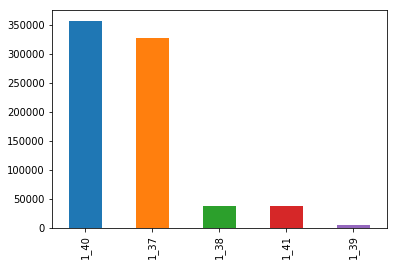

In [163]:
final.routeid.value_counts().plot(kind='bar')

In [164]:
final['routeid'].value_counts(normalize = True)

1_40    0.466674
1_37    0.426734
1_38    0.049898
1_41    0.049780
1_39    0.006915
Name: routeid, dtype: float64

In [165]:
final['weekday'].value_counts(normalize = True)

1    0.174033
2    0.170431
3    0.152230
0    0.146691
4    0.138131
5    0.119470
6    0.099014
Name: weekday, dtype: float64

In [166]:
# routes = final.routeid.value_counts()[0:2].index.tolist()
# print(routes)
# final = final[final.routeid.isin(routes)]
# final.routeid.unique()

In [167]:
# final.head()

## 5.3  Only keep the summer table

In [168]:
final.month.unique()

array([4, 3, 6, 5, 2, 1], dtype=int64)

In [169]:
final.direction.unique()

array([1, 2], dtype=int64)

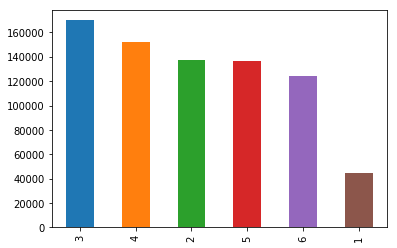

In [170]:
final.month.value_counts().plot(kind='bar')

In [171]:
final['month'].value_counts(normalize = True)

3    0.222165
4    0.199425
2    0.179596
5    0.178234
6    0.162698
1    0.057882
Name: month, dtype: float64

In [172]:
final = final.loc[final["month"].isin([6,7])]

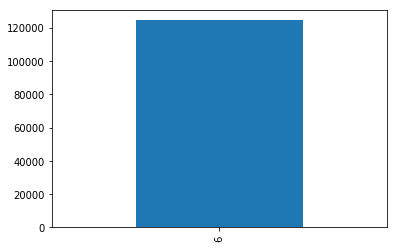

In [173]:
final.month.value_counts().plot(kind='bar')

In [174]:
final['month'].value_counts(normalize = True)

6    1.0
Name: month, dtype: float64

In [175]:
final.shape

(124402, 25)

## 5.4 Drop the year and month

In [176]:
# Do not need year, drop it
final = final.drop(['year','month'], axis=1)

In [177]:
final.dtypes

dayofservice            datetime64[ns]
tripID                           int64
progrnumber                      int64
stop_id                          int64
plannedtime_arr_stop             int64
plannedtime_dep_stop             int64
actualtime_arr_stop              int64
actualtime_dep_stop              int64
routeid                         object
direction                        int64
plannedtime_arr                  int64
plannedtime_dep                  int64
actualtime_arr                 float64
actualtime_dep                 float64
dayofservice_new                 int64
stationid                        int64
timeofarrival           datetime64[ns]
date                             int64
hour                             int64
weekday                          int64
rain                           float64
temp                           float64
wdsp                           float64
dtype: object

## 5.5 Test the final stop relation with headsign

In [178]:
def get_destinationstop(group):
    group.sort_values(['progrnumber'],ascending=False)
    max_sequence_row = group.ix[group['progrnumber'].idxmax()]
    group["route_end_stop"] = max_sequence_row.stop_id
    return group
def get_departurestop(group):
    group.sort_values(['progrnumber'],ascending=True)
    max_sequence_row = group.ix[group['progrnumber'].idxmin()]
    group["route_start_stop"] = max_sequence_row.stop_id
    return group

In [179]:
final = final.groupby(["dayofservice","tripID"]).apply(get_destinationstop)
final = final.groupby(["dayofservice","tripID"]).apply(get_departurestop)

C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [180]:
timetable = pd.read_csv("timetable.csv",dtype = {"line_ID": object})

In [181]:
timetable.columns[7]

'route_end_stop'

In [182]:
timetable_1 = timetable[timetable["line_ID"] == i]
timetable_1 

,trip_id,departure_time,prog_number,stop_headsign,new_stop_id,line_ID,weekday,route_end_stop,route_start_stop,route_start_time
0,3643.y102m.60-1-d12-1.1.O,15:40:00,1,Sandymount,226,1,y102m,380,226,15:40:00
1,3643.y102m.60-1-d12-1.1.O,15:40:47,2,Sandymount,228,1,y102m,380,226,15:40:00
2,3643.y102m.60-1-d12-1.1.O,15:41:26,3,Sandymount,229,1,y102m,380,226,15:40:00
3,3643.y102m.60-1-d12-1.1.O,15:42:30,4,Sandymount,227,1,y102m,380,226,15:40:00
4,3643.y102m.60-1-d12-1.1.O,15:43:09,5,Sandymount,230,1,y102m,380,226,15:40:00
5,3643.y102m.60-1-d12-1.1.O,15:44:03,6,Sandymount,231,1,y102m,380,226,15:40:00
6,3643.y102m.60-1-d12-1.1.O,15:45:29,7,Sandymount,1641,1,y102m,380,226,15:40:00
7,3643.y102m.60-1-d12-1.1.O,15:46:23,8,Sandymount,1642,1,y102m,380,226,15:40:00
8,3643.y102m.60-1-d12-1.1.O,15:47:19,9,Sandymount,213,1,y102m,380,226,15:40:00
9,3643.y102m.60-1-d12-1.1.O,15:48:06,10,Sandymount,214,1,y102m,380,226,15:40:00


In [183]:
timetable_stop_1 = timetable_1[["route_end_stop","route_start_stop"]].drop_duplicates()
timetable_stop_1

,route_end_stop,route_start_stop
0,380,226
4662,380,265
4893,271,226
4962,226,381
9750,7615,381


In [184]:
final.shape

(124402, 25)

In [185]:
final = pd.merge(final,timetable_stop_1, on = ["route_end_stop","route_start_stop"] ,how ="inner" )

In [186]:
final.shape

(113675, 25)

In [187]:
113675/124402

0.9137714827735889

In [189]:
final["route_end_stop"].unique()

array([ 380,  226,  271, 7615], dtype=int64)

In [190]:
final["route_start_stop"].value_counts(normalize = True)

381    0.496582
226    0.448137
265    0.055280
Name: route_start_stop, dtype: float64

In [191]:
final["route_end_stop"].value_counts(normalize = True)

380     0.496767
226     0.480765
7615    0.015817
271     0.006651
Name: route_end_stop, dtype: float64

In [192]:
final["stop_sequence_max"] = final.groupby(["dayofservice","tripID"]).progrnumber.transform(max)
final["stop_sequence_max"].unique()

array([42, 43, 21, 23, 22], dtype=int64)

In [193]:
final["stop_sequence_min"] = final.groupby(["dayofservice","tripID"]).progrnumber.transform(min)
final["stop_sequence_min"].unique()

array([ 1, 22], dtype=int64)

In [194]:
final = final[final["stop_sequence_min"] == 1]

In [195]:
final["stop_sequence_max"].value_counts(normalize = True)

42    0.775509
43    0.150335
21    0.051601
22    0.015879
23    0.006676
Name: stop_sequence_max, dtype: float64

In [196]:
final["stop_sequence_min"].value_counts(normalize = True)

1    1.0
Name: stop_sequence_min, dtype: float64

# 6. Final table clean up

## 6.1 Target Feature

In [197]:
#get rid of the timeofarrival which is the medium valibles of the table
final = final.drop(['timeofarrival','date'], axis=1)

In [198]:
final['target'] = final['actualtime_arr_stop'] - final['plannedtime_dep']

In [199]:
final.dtypes

dayofservice            datetime64[ns]
tripID                           int64
progrnumber                      int64
stop_id                          int64
plannedtime_arr_stop             int64
plannedtime_dep_stop             int64
actualtime_arr_stop              int64
actualtime_dep_stop              int64
routeid                         object
direction                        int64
plannedtime_arr                  int64
plannedtime_dep                  int64
actualtime_arr                 float64
actualtime_dep                 float64
dayofservice_new                 int64
stationid                        int64
hour                             int64
weekday                          int64
rain                           float64
temp                           float64
wdsp                           float64
route_end_stop                   int64
route_start_stop                 int64
stop_sequence_max                int64
stop_sequence_min                int64
target                   

In [200]:
dataForModel =  final[["progrnumber","weekday","hour",'rain',"temp","wdsp","target","route_start_stop","route_end_stop"]]
dataForModel['stopID'] =  final[['stop_id']]

C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [201]:
dataForModel.dtypes

progrnumber           int64
weekday               int64
hour                  int64
rain                float64
temp                float64
wdsp                float64
target                int64
route_start_stop      int64
route_end_stop        int64
stopID                int64
dtype: object

In [202]:
dataForModels = pd.get_dummies(data=dataForModel, columns=['stopID','progrnumber','weekday','hour',"route_start_stop","route_end_stop"])

In [300]:
dataForModels[(dataForModels["stopID_265"] == 1) & (dataForModels["route_end_stop_380"] == 1) & (dataForModels["route_start_stop_265"] == 1)]

,rain,temp,wdsp,target,stopID_10,stopID_12,stopID_14,stopID_15,stopID_17,stopID_18,...,hour_21,hour_22,hour_23,route_start_stop_226,route_start_stop_265,route_start_stop_381,route_end_stop_226,route_end_stop_271,route_end_stop_380,route_end_stop_7615
104917,0.0,16.6,5.0,54,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
104918,0.0,16.6,5.0,43,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
104919,0.0,16.6,5.0,114,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
104920,0.0,16.6,5.0,12,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
104949,0.0,15.1,3.0,-15,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
104950,0.0,15.1,3.0,36,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
105082,0.0,14.1,7.0,30,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
105083,0.0,14.1,7.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
105084,0.0,14.1,7.0,27,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
105085,0.0,14.1,7.0,32,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## 7.1 train models for specific route

In [203]:
# # Change csv file for specific route
# final.to_csv("final_route_145.csv",index=False)
# dataForModel.to_csv("model.csv", index =False)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#normalized_sparsedf = preprocessing.normalize(dataForModel)
scaler= StandardScaler().fit(dataForModels)
normalized_sparsed = scaler.transform(dataForModels)

In [204]:
normalized_sparsed

array([[-0.24058918,  1.06380619, -0.3438563 , ..., -0.08198362,
         1.01044007, -0.12702292],
       [-0.24058918,  1.06380619, -0.3438563 , ..., -0.08198362,
         1.01044007, -0.12702292],
       [-0.24058918,  1.06380619, -0.3438563 , ..., -0.08198362,
         1.01044007, -0.12702292],
       ...,
       [-0.24058918, -0.53105773,  1.23050125, ..., -0.08198362,
        -0.9896678 ,  7.87259507],
       [-0.24058918, -0.53105773,  1.23050125, ..., -0.08198362,
        -0.9896678 ,  7.87259507],
       [-0.24058918, -0.53105773,  1.23050125, ..., -0.08198362,
        -0.9896678 ,  7.87259507]])

In [205]:
DF = pd.DataFrame(normalized_sparsed, columns=dataForModels.columns,index= dataForModels.index)

In [206]:
DF.sample(10)

,rain,temp,wdsp,target,stopID_10,stopID_12,stopID_14,stopID_15,stopID_17,stopID_18,...,hour_21,hour_22,hour_23,route_start_stop_226,route_start_stop_265,route_start_stop_381,route_end_stop_226,route_end_stop_271,route_end_stop_380,route_end_stop_7615
36949,4.811287,-0.758895,1.492894,0.953956,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,1.105804,-0.233257,-0.997037,-0.965858,-0.081984,1.010440,-0.127023
93283,-0.240589,2.170446,-0.081463,-1.267684,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,-0.904319,-0.233257,1.002972,1.035349,-0.081984,-0.989668,-0.127023
82963,-0.240589,0.770872,0.180930,1.339552,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,-0.904319,-0.233257,1.002972,1.035349,-0.081984,-0.989668,-0.127023
62223,1.969607,-1.084378,-0.868642,-0.692860,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,-0.904319,-0.233257,1.002972,1.035349,-0.081984,-0.989668,-0.127023
102374,0.075153,0.152455,0.180930,-0.376886,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,-0.904319,-0.233257,1.002972,1.035349,-0.081984,-0.989668,-0.127023
40680,-0.240589,2.137898,-1.393428,-1.231981,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,1.105804,-0.233257,-0.997037,-0.965858,-0.081984,1.010440,-0.127023
87805,-0.240589,-0.205575,0.180930,-1.106127,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,-0.904319,-0.233257,1.002972,1.035349,-0.081984,-0.989668,-0.127023
59062,0.075153,-0.400865,-0.606249,0.345214,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,-0.904319,-0.233257,1.002972,1.035349,-0.081984,-0.989668,-0.127023
88813,1.338122,-1.442409,-0.343856,-0.305479,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,4.165972,-0.20738,-0.904319,-0.233257,1.002972,1.035349,-0.081984,-0.989668,-0.127023
110384,-0.240589,-0.205575,0.443322,-0.118037,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,...,-0.242275,-0.240040,-0.20738,-0.904319,4.287124,-0.997037,-0.965858,-0.081984,1.010440,-0.127023


In [207]:
y = DF['target']

In [208]:
# keep the whole DF in x_train_y and X_test_y which are helpful to denormalize
X_train_y, X_test_y, y_train, y_test = train_test_split(DF,y,test_size = 0.3, random_state= 0 )
X_train = X_train_y.drop(['target'],axis=1)
X_test = X_test_y.drop(['target'],axis=1)

In [209]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(200,200,200), max_iter = 1000, solver='lbfgs', \
                   alpha=0.01, activation = 'tanh', random_state = 8)

In [210]:
mlp.fit(X_train,y_train)

MLPRegressor(activation='tanh', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=8, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [211]:
predictions = mlp.predict(X_test)

In [212]:
x_mini = X_test.iloc[0]

In [213]:
mlp.predict(X_test.head(1))

array([-1.32547513])

In [214]:
X_test.head(1)

,rain,temp,wdsp,stopID_10,stopID_12,stopID_14,stopID_15,stopID_17,stopID_18,stopID_19,...,hour_21,hour_22,hour_23,route_start_stop_226,route_start_stop_265,route_start_stop_381,route_end_stop_226,route_end_stop_271,route_end_stop_380,route_end_stop_7615
68369,-0.240589,-0.85654,-1.131035,-0.10718,-0.107474,-0.107306,-0.107516,-0.107432,-0.10739,-0.107432,...,4.127546,-0.24004,-0.20738,-0.904319,-0.233257,1.002972,1.035349,-0.081984,-0.989668,-0.127023


In [215]:
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.9339925240689576

In [216]:
predictionsTestClass = pd.DataFrame({'Actual Delay': X_test_y.target, 'Prediction Delay': predictions})
predictionsTestClass.head(10)

,Actual Delay,Prediction Delay
68369,-1.281073,-1.325475
83049,-0.854418,-0.760606
80930,0.865591,0.939633
32289,-0.762482,-0.804587
73033,-1.345339,-1.275515
14035,1.129795,1.476661
88487,-1.241799,-1.173819
58134,0.895938,0.899577
7754,1.389537,1.263679
21924,0.681718,0.643267


In [217]:
X_test_y.target = predictions
prediction = scaler.inverse_transform(X_test_y)

C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [218]:
X_test_y.target = y_test
actual = scaler.inverse_transform(X_test_y)

C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [219]:
DF_actual = pd.DataFrame(actual, columns=dataForModels.columns,index= X_test_y.index)
DF_prediction = pd.DataFrame(prediction, columns=dataForModels.columns,index= X_test_y.index)
predictionsTestClass = pd.DataFrame({'Actual': DF_actual.target, 'Prediction': DF_prediction.target})
predictionsTestClass.sample(10)

,Actual,Prediction
33981,753.0,719.721072
65085,2873.0,2656.880298
103713,2441.0,1935.002822
17034,870.0,904.773612
29282,1313.0,1403.518164
92270,242.0,286.406271
37694,79.0,124.472005
16053,1934.0,1864.394467
19393,1669.0,2077.290682
68207,2457.0,2362.259985


In [220]:
from itertools import groupby
def back_from_dummies(df):
    result_series = {}

    # Find dummy columns and build pairs (category, category_value)
    dummmy_tuples = [(col.split("_")[0],col) for col in df.columns if "_" in col]

    # Find non-dummy columns that do not have a _
    non_dummy_cols = [col for col in df.columns if "_" not in col]

    # For each category column group use idxmax to find the value.
    for dummy, cols in groupby(dummmy_tuples, lambda item: item[0]):

        #Select columns for each category
        dummy_df = df[[col[1] for col in cols]]

        # Find max value among columns
        max_columns = dummy_df.idxmax(axis=1)

        # Remove category_ prefix
        result_series[dummy] = max_columns.apply(lambda item: item.split("_")[1])

    # Copy non-dummy columns over.
    for col in non_dummy_cols:
        result_series[col] = df[col]

    # Return dataframe of the resulting series
    return pd.DataFrame(result_series)

In [221]:
back_actual = back_from_dummies(DF_actual)
back_prediction = back_from_dummies(DF_prediction)

In [222]:
back_actual["predicted_target"] = DF_prediction.target

In [223]:
back_actual[["progrnumber","target","predicted_target"]].sample(10)

,progrnumber,target,predicted_target
91555,16,1160.0,991.041716
22080,34,2307.0,2558.337254
54035,2,94.0,41.940317
68945,12,549.0,654.183022
35201,39,3453.0,2790.616077
725,32,2800.0,2678.816662
92931,31,2487.0,1840.814715
23454,40,2625.0,3130.598395
103635,25,2371.0,2424.459085
99555,9,415.0,298.788202


In [224]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(DF_actual.target,DF_prediction.target)

207.78713480433757

In [225]:
from sklearn.metrics import r2_score
r2_score(DF_actual.target,DF_prediction.target)

0.9339925240689576

In [226]:
from sklearn.externals import joblib
modelname =  i + ".sav"
normname = "n"+ i +".sav"
joblib.dump(mlp,modelname)
joblib.dump(scaler, normname)

['n1.sav']

In [227]:
columnname = "c" +i +".sav"
dataForModels.head(1).to_csv(columnname,header=True, index=False,columns = dataForModels.columns)

In [228]:
dataForModels.head(1)

,rain,temp,wdsp,target,stopID_10,stopID_12,stopID_14,stopID_15,stopID_17,stopID_18,...,hour_21,hour_22,hour_23,route_start_stop_226,route_start_stop_265,route_start_stop_381,route_end_stop_226,route_end_stop_271,route_end_stop_380,route_end_stop_7615
0,0.0,18.8,8.0,2061,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [229]:
dataForModels_1 = pd.read_csv(columnname)
dataForModels_1

,rain,temp,wdsp,target,stopID_10,stopID_12,stopID_14,stopID_15,stopID_17,stopID_18,...,hour_21,hour_22,hour_23,route_start_stop_226,route_start_stop_265,route_start_stop_381,route_end_stop_226,route_end_stop_271,route_end_stop_380,route_end_stop_7615
0,0.0,18.8,8.0,2061,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## 7.2 Use the model

In [7]:
i="1"
from sklearn.externals import joblib
modelname =  i + ".sav"
normname = "n"+ i +".sav"
columnname = "c" +i +".csv"
loaded_mlp = joblib.load(modelname)
loaded_scaler = joblib.load(normname)
columnsname = pd.read_csv(columnname).columns
print(loaded_mlp)

MLPRegressor(activation='tanh', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=8, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [231]:
dataForModel.dtypes

progrnumber           int64
weekday               int64
hour                  int64
rain                float64
temp                float64
wdsp                float64
target                int64
route_start_stop      int64
route_end_stop        int64
stopID                int64
dtype: object

In [232]:
dataForModels.columns

Index(['rain', 'temp', 'wdsp', 'target', 'stopID_10', 'stopID_12', 'stopID_14',
       'stopID_15', 'stopID_17', 'stopID_18',
       ...
       'hour_21', 'hour_22', 'hour_23', 'route_start_stop_226',
       'route_start_stop_265', 'route_start_stop_381', 'route_end_stop_226',
       'route_end_stop_271', 'route_end_stop_380', 'route_end_stop_7615'],
      dtype='object', length=163)

In [8]:
data_example = [{"stopID_265": 1,"progrnumber_22": 1, "rain":0,"temp":16.6,"weekday_2":2,"hour_15":1,"wdsp":0,"route_start_stop_226":1,"route_end_stop_380":1}]

In [9]:
example = pd.DataFrame(data_example, columns= columnsname )
example = example.fillna(0)

In [10]:
example

,rain,temp,wdsp,target,stopID_10,stopID_12,stopID_14,stopID_15,stopID_17,stopID_18,...,hour_21,hour_22,hour_23,route_start_stop_226,route_start_stop_265,route_start_stop_381,route_end_stop_226,route_end_stop_271,route_end_stop_380,route_end_stop_7615
0,0,16.6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0


In [11]:
DF_n = scaler.transform(example)
DF_n = pd.DataFrame(DF_n, columns = columnsname)
prediction =mlp. DF_n.drop["target"]

NameError: name 'scaler' is not defined

In [12]:
normalized_sparsed = loaded_scaler.transform(example)

In [13]:
DF = pd.DataFrame(normalized_sparsed, columns=columnsname)
DF

,rain,temp,wdsp,target,stopID_10,stopID_12,stopID_14,stopID_15,stopID_17,stopID_18,...,hour_21,hour_22,hour_23,route_start_stop_226,route_start_stop_265,route_start_stop_381,route_end_stop_226,route_end_stop_271,route_end_stop_380,route_end_stop_7615
0,-0.240537,0.348431,-2.444134,-1.399617,-0.106969,-0.107263,-0.107095,-0.107305,-0.107221,-0.107179,...,-0.241777,-0.239547,-0.20696,1.109711,-0.241899,-0.993188,-0.962243,-0.081823,1.006487,-0.126772


In [14]:
X_example = DF.drop(["target"],axis = 1)
X_example

,rain,temp,wdsp,stopID_10,stopID_12,stopID_14,stopID_15,stopID_17,stopID_18,stopID_19,...,hour_21,hour_22,hour_23,route_start_stop_226,route_start_stop_265,route_start_stop_381,route_end_stop_226,route_end_stop_271,route_end_stop_380,route_end_stop_7615
0,-0.240537,0.348431,-2.444134,-0.106969,-0.107263,-0.107095,-0.107305,-0.107221,-0.107179,-0.107221,...,-0.241777,-0.239547,-0.20696,1.109711,-0.241899,-0.993188,-0.962243,-0.081823,1.006487,-0.126772


In [17]:
target = loaded_mlp.predict(X_example)
target

array([0.10815341])

In [18]:
target = mlp.predict(X_example)

NameError: name 'mlp' is not defined

In [19]:
target = mlp.predict(X_example)
target

NameError: name 'mlp' is not defined

In [20]:
DF['target'] = target

In [21]:
actual = loaded_scaler.inverse_transform(DF)
actual = pd.DataFrame(actual, columns=columnsname)
actual['target']

0    1691.740588
Name: target, dtype: float64